<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd, numpy as np #импортируем библиотеки pandas
from sklearn.model_selection import train_test_split #импортируем функцию train_test_split
from sklearn.linear_model import LinearRegression #импортируем библиотеку LinearRegression
from sklearn.tree import DecisionTreeRegressor #импортируем библиотеку DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor #импортируем библиотеку RandomForestRegressor
from sklearn.model_selection import cross_val_score #импортируем cross_val_score
from sklearn.model_selection import GridSearchCV #импортируем функцию GridSearchCV
from sklearn.model_selection import RandomizedSearchCV #импортируем функцию RandomizedSearchCV
from lightgbm import LGBMRegressor #импортируем библиотеку LGBMRegressor
from catboost import CatBoostRegressor #импортируем библиотеку CatBoostRegressor
from sklearn.metrics import mean_squared_error #импортируем функцию mean_squared_error
from sklearn.model_selection import TimeSeriesSplit #импортируем библиотеку TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose #импортируем библиотеку seasonal_decompose
import matplotlib.pyplot as plt #импортируем библиотеку plt
import statsmodels.tsa.stattools as ts #импортируем библиотеку ts

import time #импортируем библиотеку time
import warnings #импортируем библиотеку warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) #считаем файл с данными и сохраним в data
data.sort_index(inplace=True)

display(data) #выведем таблицу data
data.info() #получим общую информацию о данных в таблице data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Поменяем интервал временного ряда.

In [3]:
data_resample_hour = data.resample('1H').sum() #ресемплируем по часам

Проверим типы.

In [4]:
data_resample_hour.dtypes #выведем типы

num_orders    int64
dtype: object

### Вывод

Временной ряд представлен от 2018-03-01 00:00:00 до 2018-08-31 23:50:00. Ресемплирование сделали по часам. Тип данных столбца количества заказов int64. Столбец с датой является индексом.

## Анализ

Проанализируем временной ряд. Для этого поменяем интервалы и построим графики.

Сперва напишем функцию ресемплирования и построения графиков.

In [5]:
def resample_plot_data(data, period):
    data = data.resample(period).sum() #ресемплирование
    data.plot(figsize=(16, 6)) #построение графика

Ресемплируем по часам и строим график.

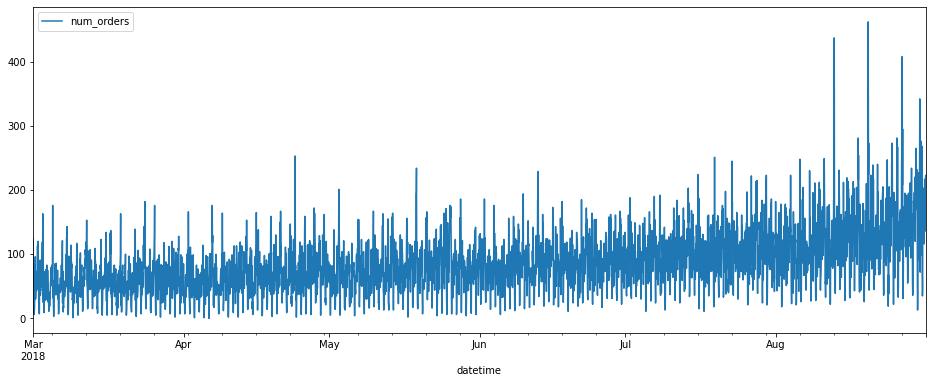

In [6]:
resample_plot_data(data, '1H') #применим функцию resample_plot_data

Ресемплируем по месяцам и строим график.

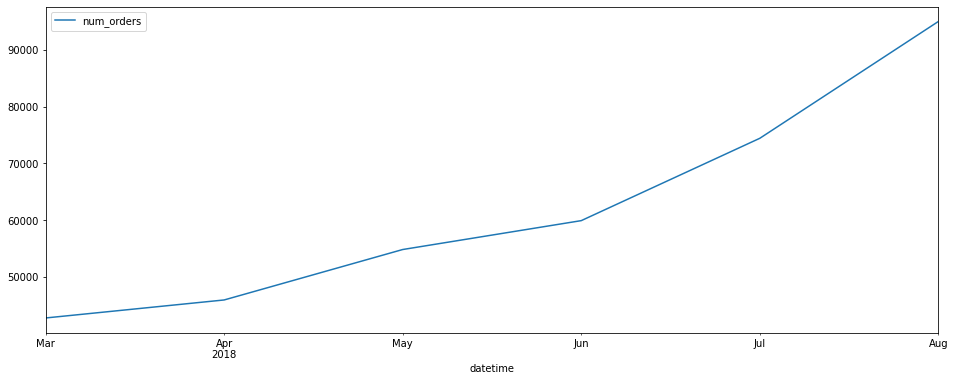

In [7]:
resample_plot_data(data, '1M') #применим функцию resample_plot_data

Ресемплируем по дням и строим график.

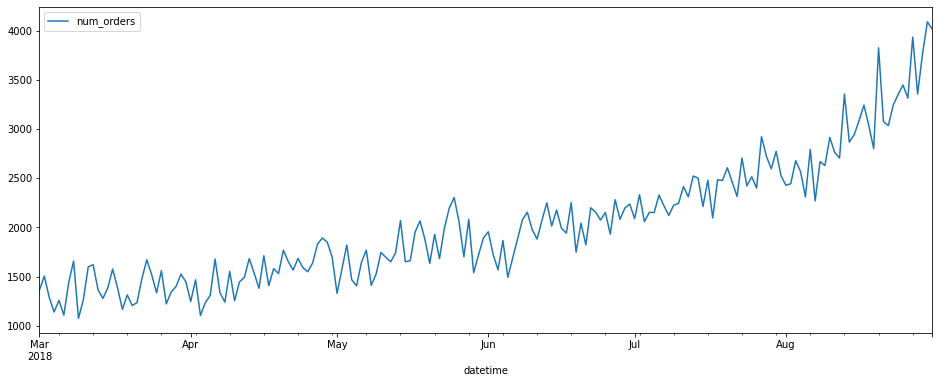

In [8]:
resample_plot_data(data, '1D') #применим функцию resample_plot_data

Ресемплируем по неделям и строим график.

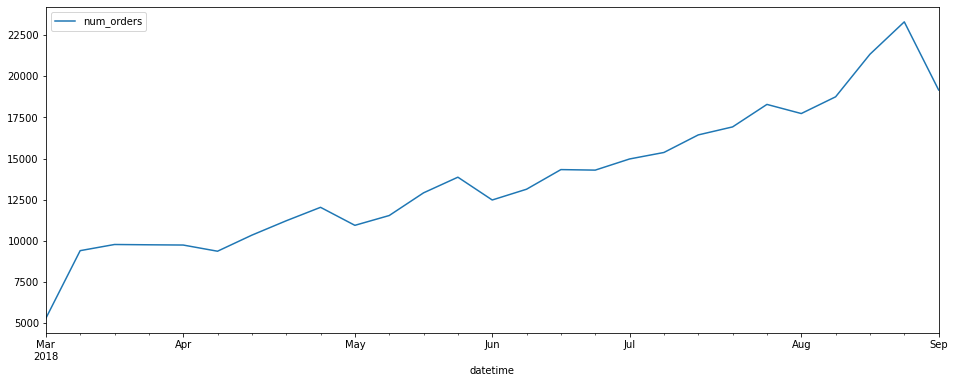

In [9]:
resample_plot_data(data, '1W') #применим функцию resample_plot_data

Исходя из графиков, видим, что количество заказов по месяцам, часам, дням и неделям не одинаковое. Для более детального анализа разложим временноя ряд по трендам и сезонности.

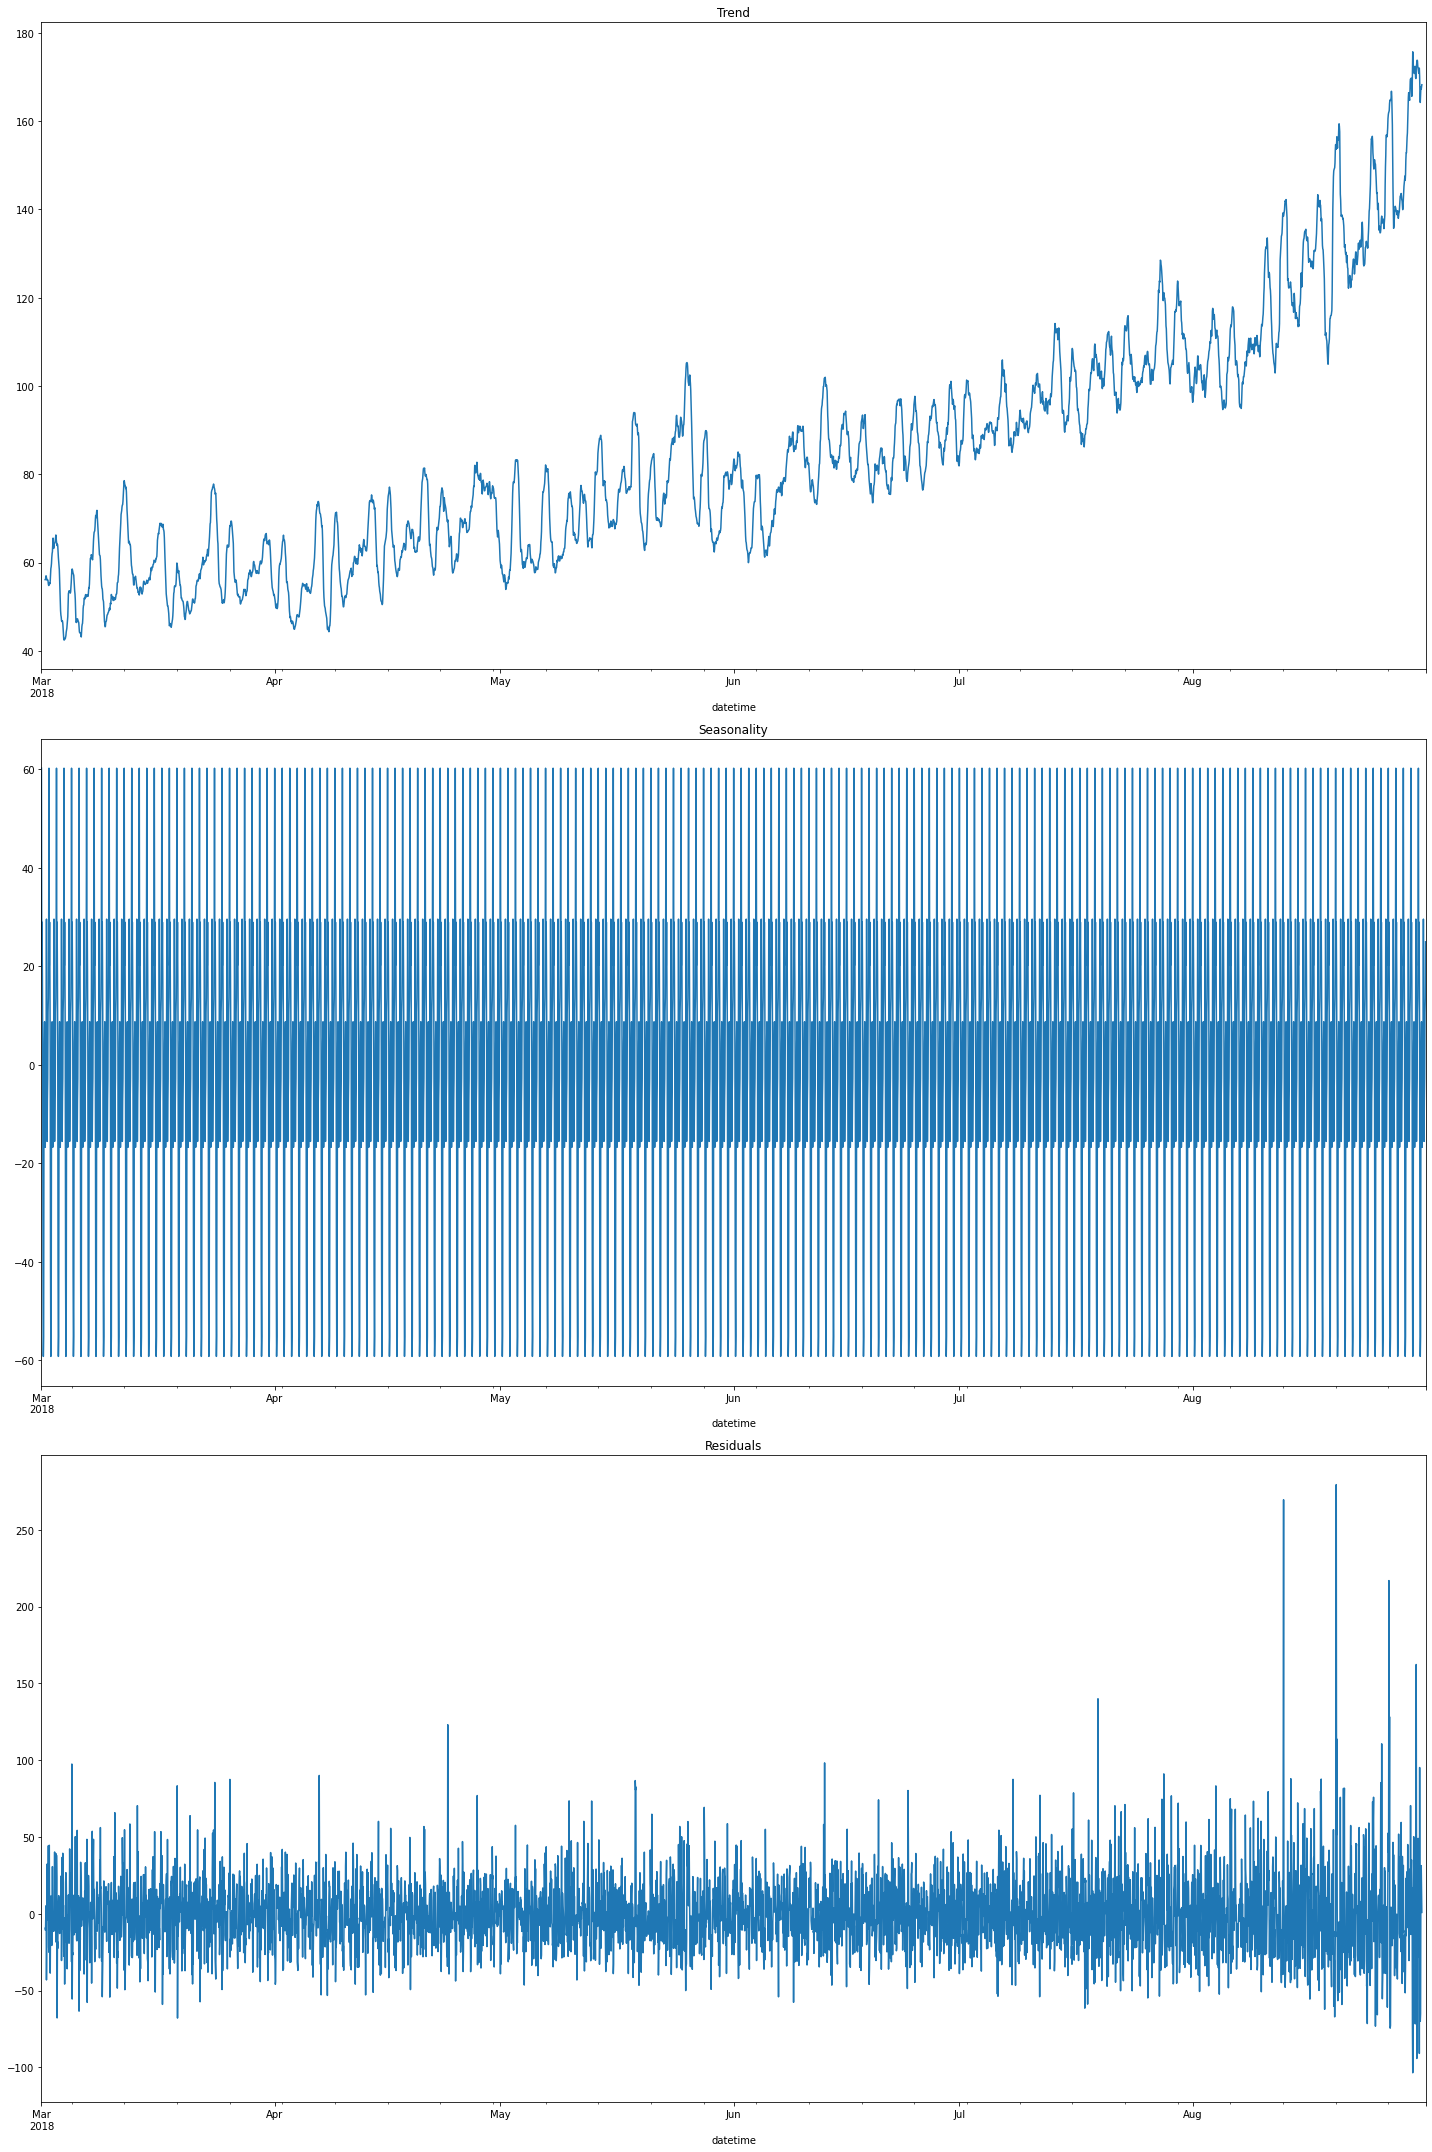

In [10]:
decomposed = seasonal_decompose(data_resample_hour['num_orders']) #декомпозируем data_resample_hour['num_orders']

plt.figure(figsize=(20, 30))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)


decomposed.trend.plot(ax=plt.gca()) #тренд
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())  #сезонность
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())  #остатки
plt.title('Residuals')
plt.tight_layout()

Тренд связан с временем года. Летом количество заказов увеличивается, так как настает период отпусков. А сезонность с периодом меньше месяца. Исследуем их дальше.

Разложим тренд по месяцам, сделав срез с мая по август.

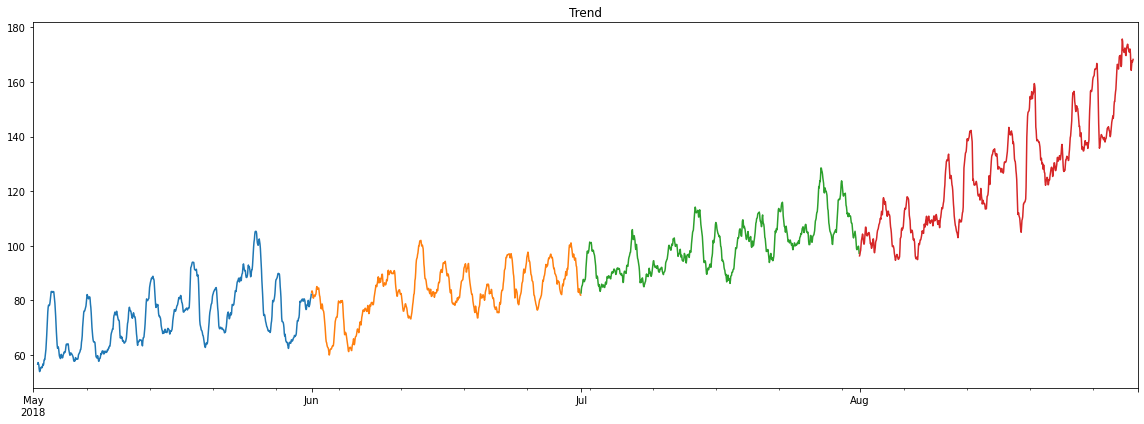

In [11]:
decomposed_month = seasonal_decompose(data_resample_hour['2018-05':'2018-08']['num_orders']) #декомпозируем data_resample_hour['num_orders']


plt.figure(figsize=(16, 6))

decomposed_month.trend.resample('1M').plot(ax=plt.gca()) #выполним ресемплирование по месяцам и выведем тренд
plt.title('Trend')

plt.tight_layout()

Разложим тренд по дням, сделав срез за июль.

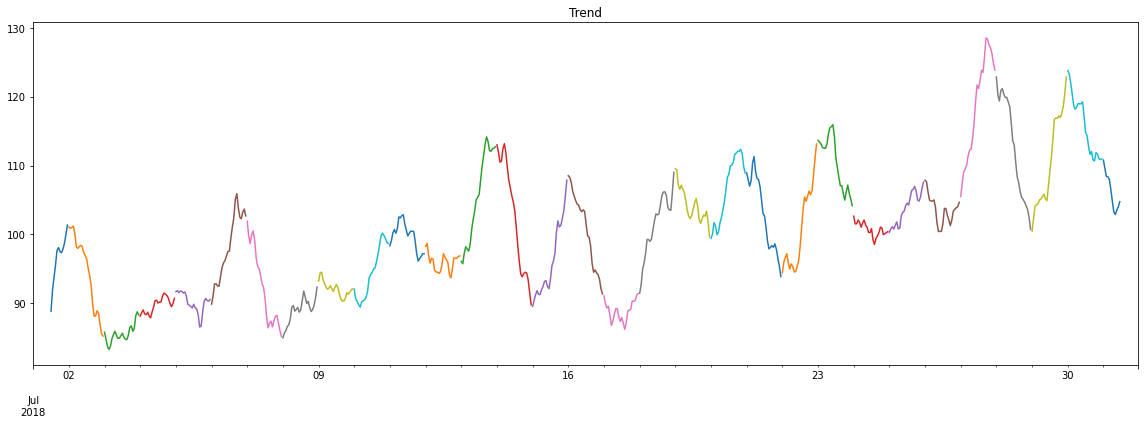

In [12]:
decomposed_day = seasonal_decompose(data_resample_hour['2018-07-01':'2018-07-31']['num_orders']) #декомпозируем data_resample_hour['num_orders']

plt.figure(figsize=(16, 6))

decomposed_day.trend.resample('1D').plot(ax=plt.gca()) #выполним ресемплирование по дням и выведем тренд
plt.title('Trend')

plt.tight_layout()

Разложим остатки по неделям, сделав срез с 1-го по 14-ое августа.

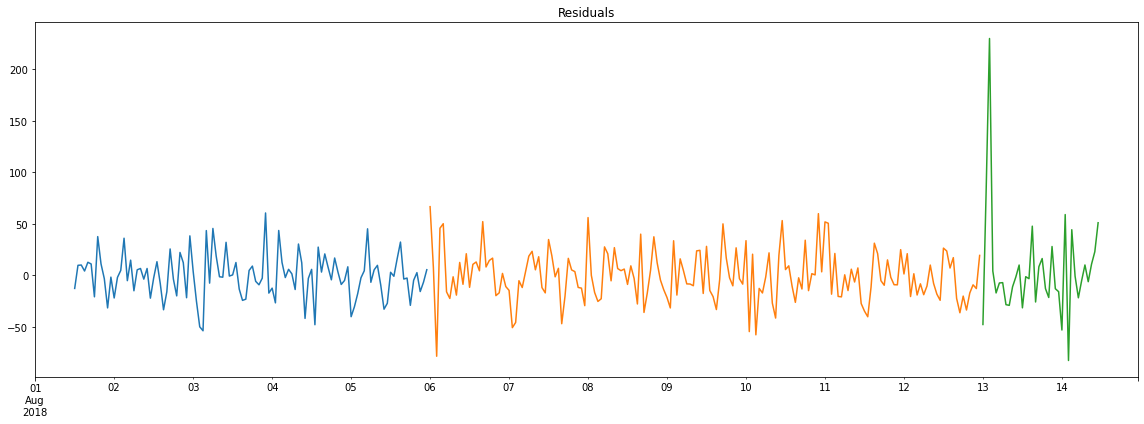

In [13]:
decomposed_week = seasonal_decompose(data_resample_hour['2018-08-01':'2018-08-14']['num_orders']) #декомпозируем data_resample_hour['num_orders']

plt.figure(figsize=(16, 6))

decomposed_week.resid.resample('1W').plot() #выполним ресемплирование по неделям и выведем остатки
plt.title('Residuals')

plt.tight_layout()

Разложим сезонность по часам, сделав срез с 1-ое по 2-ое августа.

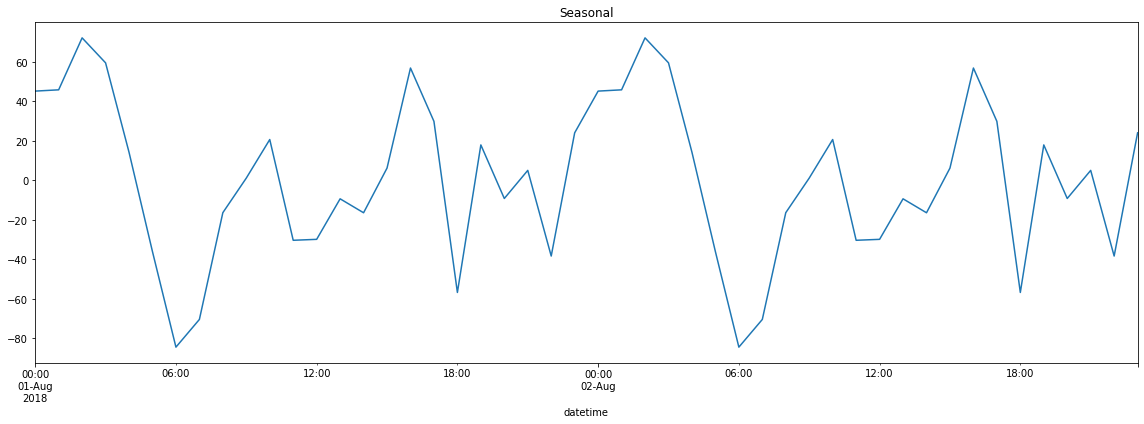

In [14]:
decomposed_hour = seasonal_decompose(data_resample_hour['2018-08-01':'2018-08-02']['num_orders']) #декомпозируем data_resample_hour['num_orders']

plt.figure(figsize=(16, 6))

decomposed_hour.seasonal.plot() #выведем сезонность
plt.title('Seasonal')
plt.tight_layout()

Также проверим ряд на стационарность, применив тест Дики-Фуллера.

In [15]:
def test_diki_f(series):
    p_value = ts.adfuller(series)[1] #вычислим p-value
    print(f"p-value = {p_value}") #выведем p-value
    if p_value > 0.05: #если p-value > 0.05
        print('Ряд нестационарный')
    else:
        print('Ряд стационарный')

In [16]:
test_diki_f(data_resample_hour['num_orders']) #применим тест к data_hour['num_orders']

p-value = 0.028940051402612906
Ряд стационарный


### Вывод

Итак, выяснили, что ряд является стационарным, значит дифферинцировать не нужно.

Далее, построив график по сезонной компоненте определили, что количество заказов по месяцам не одинаковое. Также по дням недели: в какие-то дни систематически больше, чем в другие. По часам также из графика видим, что спрос на такси возрастает в конце дня, а затем падает в ранние утреннние часы.

То есть эти временные компоненты оказывают влияние на целевой признак, их надо включать в модель.

## Обучение

Получается из анализа необходимо включить в признаки день недели, часы, месяц и число. И также отстающие значения и скользящее среднее. 

Напишем функцию для создания признаков.

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour #час
    data['month'] = data.index.month #месяц
    data['day'] = data.index.day #день
    data['dayofweek'] = data.index.dayofweek #день недели
    
    for lag in range(1, max_lag + 1): #в цикле добавим отстающие значения в таблицу функцией shift
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() #добавим скользящее среднее

Применим функцию к данным, определив количество лагов - 2 и скользящее среднее, кратное 24 часам, т.к. есть дневная цикличность.

In [18]:
make_features(data_resample_hour, 2, 24) #применим функцию make_features к data_resample_hour

Разделим данные на обучающую и тестовую выборки.

In [19]:
train, test = train_test_split(data_resample_hour, shuffle=False, test_size=0.1) # функцией train_test_split разделим на обучающую и тестовую выборки

Удалим нули.

In [20]:
train = train.dropna() #удалим нули

In [21]:
train

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,,,
2018-03-02 00:00:00,90,0,3,2,4,58.0,113.0,56.833333
2018-03-02 01:00:00,120,1,3,2,4,90.0,58.0,55.416667
2018-03-02 02:00:00,75,2,3,2,4,120.0,90.0,56.875000
2018-03-02 03:00:00,64,3,3,2,4,75.0,120.0,57.041667
2018-03-02 04:00:00,20,4,3,2,4,64.0,75.0,56.958333
...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,9,8,13,0,91.0,39.0,134.041667
2018-08-13 10:00:00,156,10,8,13,0,137.0,91.0,135.250000
2018-08-13 11:00:00,144,11,8,13,0,156.0,137.0,137.250000


Выделим признаки для тестовой и обучающей выборок.

In [22]:
features_train = train.drop(['num_orders'], axis=1) #выделим признаки
target_train = train['num_orders'] #выделим целевой признак num_orders

In [23]:
features_test = test.drop(['num_orders'], axis=1) #выделим признаки
target_test = test['num_orders'] #выделим целевой признак num_orders

Напишем функцию для расчета времени выполнения обучения модели.

In [24]:
def getTimeModel(grid, features_train, target_train):
    start = time.time() #получим текущее время и запишем в переменную start
    grid.fit(features_train, target_train) #выполним обучение модели
    stop = time.time() #получим время после выполнения обучения и запишем в переменную stop
    total_time = stop - start #из stop вычтем start
    print('Время выполнения обучения модели', total_time) #выведем время выполнения обучения модели
    print('Лучшее значение метрики rmse:', -grid.best_score_) #выведем наилучший показатель
    print('Лучшие параметры:', grid.best_params_) #выведем наилучшие параметры
    return total_time, -grid.best_score_, grid.best_params_ #вернем время, метрику и наилучшие параметры

In [25]:
data_result = []
rmse = 0
best_params = {}

Поскольку мы имеем дело с временным рядом, обычная кроссвалидация для подбора гиперпараметров не подойдет. Для этого будем использовать модуль TimeSeriesSplit. 

In [26]:
tscv = TimeSeriesSplit(n_splits = 3)

Обучим различные модели.

###### Модель дерева решений

In [27]:
parametres = {'max_depth': range(1, 20, 2)} #определим гиперпараметры

model_dt = DecisionTreeRegressor(random_state=12345)
search_cv = GridSearchCV(model_dt,
                         parametres,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv) #применим GridSearchCV для модели model_dt
total_time, rmse, best_params = getTimeModel(search_cv, features_train, target_train) #применим функцию getTimeModel

Время выполнения обучения модели 0.27522730827331543
Лучшее значение метрики rmse: 31.507217654923405
Лучшие параметры: {'max_depth': 7}


Добавим полученные результаты в таблицу.

In [28]:
data_result.append(['DecisionTreeRegressor', total_time, rmse, best_params]) #добавим total_time, rmse, best_params в data_result

###### Модель линейной регрессии

In [29]:
start = time.time() #получим текущее время и запишем в переменную start

model_lr = LinearRegression()
cross_val = cross_val_score(model_lr,
                            features_train,
                            target_train,
                            scoring='neg_root_mean_squared_error',
                            cv=tscv) #применим cross_val_score для модели model_lr

stop = time.time() #получим время после выполнения обучения и запишем в переменную stop
total_time = stop - start #из stop вычтем start
print('Лучшее значение метрики rmse для модели линейной регрессии:', -cross_val.mean())

Лучшее значение метрики rmse для модели линейной регрессии: 32.512191907091285


Добавим полученные результаты в таблицу.

In [30]:
data_result.append(['LinearRegression', total_time, -cross_val.mean()]) #добавим total_time, -cross_val.mean() в data_result

###### Модель случайного леса

In [31]:
parametres = {'max_depth': range(1, 12, 2), #определим гиперпараметры
              'n_estimators': range(10, 15, 5)}

model_rf = RandomForestRegressor(random_state=12345)
r_search_cv = RandomizedSearchCV(model_rf,
                                 parametres,
                                 scoring='neg_root_mean_squared_error',
                                 cv=tscv) #применим RandomizedSearchCV для модели model_rf
total_time, rmse, best_params = getTimeModel(r_search_cv, features_train, target_train) #применим функцию getTimeModel

Время выполнения обучения модели 0.7978711128234863
Лучшее значение метрики rmse: 28.419346204750166
Лучшие параметры: {'n_estimators': 10, 'max_depth': 11}


Добавим полученные результаты в таблицу.

In [32]:
data_result.append(['RandomForestRegressor', total_time, rmse, best_params]) #добавим total_time, rmse, best_params в data_result

###### Модель LGBMRegressor

In [33]:
parametres = {'max_depth': range(1, 20, 2), #определим гиперпараметры
              'n_estimators': range(10, 20, 2)}

model_lgbm = LGBMRegressor(random_state=12345, learning_rate=1, n_jobs=-1)
grid_lgbm = GridSearchCV(model_lgbm,
                         parametres,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv) #применим GridSearchCV для модели model_lgbm
total_time, rmse, best_params = getTimeModel(grid_lgbm, features_train, target_train) #применим функцию getTimeModel

Время выполнения обучения модели 79.57119250297546
Лучшее значение метрики rmse: 28.170180001280993
Лучшие параметры: {'max_depth': 3, 'n_estimators': 12}


Добавим полученные результаты в таблицу.

In [34]:
data_result.append(['LGBMRegressor', total_time, rmse, best_params]) #добавим total_time, rmse, best_params в data_result

###### Модель CatBoostRegressor

In [35]:
parametres = {'max_depth': range(1, 20, 2), #определим гиперпараметры
              'n_estimators': range(10, 20, 2)}
cat_features = ['hour', 'dayofweek']
model_cbr = CatBoostRegressor(cat_features=cat_features, random_state=12345, learning_rate=1)
grid_cbr = GridSearchCV(model_cbr,
                        parametres,
                        scoring='neg_root_mean_squared_error',
                        cv=tscv) #применим GridSearchCV для модели model_cbr
total_time, rmse, best_params = getTimeModel(grid_cbr, features_train, target_train) #применим функцию getTimeModel

0:	learn: 26.7288195	total: 46.3ms	remaining: 417ms
1:	learn: 23.6527413	total: 46.8ms	remaining: 187ms
2:	learn: 23.1699595	total: 47ms	remaining: 110ms
3:	learn: 22.6741891	total: 47.4ms	remaining: 71.1ms
4:	learn: 22.1597026	total: 47.7ms	remaining: 47.7ms
5:	learn: 21.8660288	total: 48.1ms	remaining: 32ms
6:	learn: 21.7245398	total: 48.4ms	remaining: 20.7ms
7:	learn: 21.6146794	total: 48.8ms	remaining: 12.2ms
8:	learn: 21.4461396	total: 49.1ms	remaining: 5.45ms
9:	learn: 21.2177633	total: 49.4ms	remaining: 0us
0:	learn: 29.0148285	total: 764us	remaining: 6.88ms
1:	learn: 25.5924955	total: 1.77ms	remaining: 7.1ms
2:	learn: 24.7372423	total: 2.38ms	remaining: 5.55ms
3:	learn: 24.1878636	total: 2.93ms	remaining: 4.39ms
4:	learn: 23.8081211	total: 3.46ms	remaining: 3.46ms
5:	learn: 23.4600044	total: 3.94ms	remaining: 2.62ms
6:	learn: 22.9523654	total: 4.43ms	remaining: 1.9ms
7:	learn: 22.8684613	total: 5.03ms	remaining: 1.26ms
8:	learn: 22.6436315	total: 5.53ms	remaining: 614us
9:	lear

Добавим полученные результаты в таблицу.

In [36]:
data_result.append(['CatBoostRegressor', total_time, rmse, best_params]) #добавим total_time, rmse, best_params в data_result

Выведем таблицу с полученными результатами.

In [37]:
data_result = pd.DataFrame(data_result)

In [38]:
data_result.columns =['Модель', 'Время обучения', 'RMSE', 'Гиперпараметры']

In [39]:
data_result

,Модель,Время обучения,RMSE,Гиперпараметры
0,DecisionTreeRegressor,0.275227,31.507218,{'max_depth': 7}
1,LinearRegression,0.015125,32.512192,None
2,RandomForestRegressor,0.797871,28.419346,"{'n_estimators': 10, 'max_depth': 11}"
3,LGBMRegressor,79.571193,28.170180,"{'max_depth': 3, 'n_estimators': 12}"
4,CatBoostRegressor,160.238710,27.843134,"{'max_depth': 3, 'n_estimators': 14}"


### Вывод

Наилучшее значение метрики rmse 27.8 показывает модель CatBoostRegressor при max_depth равном 3 и n_estimators равном 14, при времени выполнения - 160 секунд.

## Тестирование

Протестируем модель CatBoostRegressor на тестовой выборке.

In [40]:
cat_features = ['hour', 'dayofweek']
model_cbr = CatBoostRegressor(cat_features=cat_features, random_state=12345, learning_rate=1, max_depth=3, n_estimators=14)
model_cbr.fit(features_train, target_train) #обучим модель
predictions_test = model_cbr.predict(features_test) #получим предсказания модели на тестовой выборке
rmse = mean_squared_error(target_test, predictions_test, squared=False)
print('Значение метрики rmse:', rmse) #выведем показатель

0:	learn: 32.0289102	total: 1.23ms	remaining: 15.9ms
1:	learn: 28.0165766	total: 2.65ms	remaining: 15.9ms
2:	learn: 26.6375311	total: 3.5ms	remaining: 12.8ms
3:	learn: 25.5623608	total: 4.48ms	remaining: 11.2ms
4:	learn: 25.2813099	total: 5.85ms	remaining: 10.5ms
5:	learn: 24.9627159	total: 7.01ms	remaining: 9.35ms
6:	learn: 24.7691982	total: 8.04ms	remaining: 8.04ms
7:	learn: 24.5372618	total: 8.86ms	remaining: 6.64ms
8:	learn: 24.4490464	total: 10ms	remaining: 5.57ms
9:	learn: 24.1928027	total: 11.1ms	remaining: 4.42ms
10:	learn: 23.8672275	total: 12ms	remaining: 3.27ms
11:	learn: 23.8426287	total: 13.1ms	remaining: 2.19ms
12:	learn: 23.7708037	total: 14.4ms	remaining: 1.1ms
13:	learn: 23.6743242	total: 15.6ms	remaining: 0us
Значение метрики rmse: 46.69399907367


### Вывод

Значение метрики rmse на тестовой выборке модели CatBoostRegressor получилось 46.7 (меньше 48).

## Общий вывод

Таким образом, проанализировав временной ряд, выяснили, что количество заказов зависит от времени года, дня недели, времени в течение дня. Далее обучив различные модели, получили, что наилучший показатель rmse дает модель CatBoostRegressor при max_depth равном 3 и n_estimators равном 14.

# <font color='orange'>Рекомендации 🔥</font>
* Анализ временных рядов на python https://habr.com/ru/company/ods/blog/327242/
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k
* Проверить ряд на стационарность можно с помощью теста Дики-Фуллера http://distrland.blogspot.com/2020/06/python_28.html
* Хочешь подтянуть математику для DS?) https://academy.stepik.org/math-for-data-science
* Результаты обучения моделей можно визуализировать 😎 https://www.datatechnotes.com/2019/08/elasticnet-regression-example-in-python.html
* В нашем деле нужно быть всегда в курсе всех новинок, новостей и тд, вот тут публикуют новости в области DS: https://www.infoq.com/data-analysis/news/
* Всем аналитикам данных рекомендую книгу Даниела Канемана "Думай медленно, решай быстро"